# Goal: Use a smart contract to coordinate decentralized optimization
This can model federated machine learning or federated optimization problems

We will use the Alternating Direction Method of Multipliers, or ADMM, as the theoretical framework for breaking our problem into ADMM steps.  The general idea is:
- Local optmization problems performed locally, based on the last global estimate
- An aggregator gathers together the local solutions, then updates the global variable estimate
- When the global variable converges, we have reached consensus and the problem is solved

We will use Python to perform local computations, then use a smart contract to act as the aggregator step.



### Aggregator:
The aggregator must:
- Accept state updates from participants
- Assess whether a sufficient number of participants have submitted updates
  - When they have, compute the global variable
- Assess whether the problem is 'solved' to sufficient accuracy
  - If solved, make the global solution available and alert participants
  - If not solved, make the new global estimate availabel and alert participants.

We will first examine a federated/private blockchain, where we have a whitelist of allowable participants and know that we can compute the update when all participants on the whitelist have submitted updates. 

# Alternating Direction Method of Multipliers
We would like to combine the generous convergence requirements of the method of multipliers (using augmented lagrangians) and the decomposability of dual decomposition. 

Assuming we have a problem of the form:
$$
\begin{align}
\min_x &\quad f(x) + g(z)\\
\text{s.t.}&\quad Ax+Bz = c
\end{align}
$$
which can represent a problem in a single variable which is separable into parts. We form the augmented Lagrangian:
$$
L_{\rho}(x,y,z) = f(x)+g(z)+ y^T (Ax + Bz - c) + (\rho/2) ||Ax + Bz - c||^2_2
$$
we now consider the update iterations:
$$
\begin{align}
x^{k+1} &:= \quad \text{argmin}_x \; L_{\rho}(x      ,y^k,z^k) \\
z^{k+1} &:= \quad \text{argmin}_z \; L_{\rho}(x^{k+1},y  ,z^k) \\
y^{k+1} &:= \quad y^k + \rho(Ax^{k+1} + Bz^{k+1} - c)
\end{align}
$$
Separating the minimization into two steps, each over a single set of variables, is what allows for the decomposition. 

### Scaled form 
A more convenient form for tracking convergence can be attained by considering a residual $r=Ax+Bz-c$ on the constraints, in which case
$$
y^T r + \frac{\rho}{2}\lVert r \rVert^2_2 \quad = \quad \frac{\rho}{2}\lVert r + \frac{1}{\rho}y \rVert^2_2 - \frac{1}{2\rho}||y||^2_2 \quad = \quad \frac{\rho}{2}\lVert r + u \rVert^2_2 - \frac{\rho}{2}\lVert u \rVert^2_2
$$
where the 2-norm is expanded into a quadratic term to allow for collection of the $y$ terms. This allows the ADMM updates to be expressed as:
$$
\begin{align}
x^{k+1} &:= \quad \text{argmin}_x \; f(x) + \frac{\rho}{2}\lVert Ax + Bz^k - c + u^k \rVert^2_2 \\
z^{k+1} &:= \quad \text{argmin}_z \; g(x) + \frac{\rho}{2}\lVert Ax^{k+1} + Bz - c + u^k \rVert^2_2 \\
u^{k+1} &:= \quad u^k + Ax^{k+1} + Bz^{k+1} - c
\end{align}
$$

# Simplest ADMM example

$$
\begin{align}
\min_{x,z}  & \quad x^2 + 2z^2 \\
\text{s.t.} & \quad x + z = 4
\end{align}
$$

In standard ADMM form, $A=1,\; B=1,\; c=4,\; f=x^2,\; g=2z^2$ and the Augmented Lagrangian is:
$$
\begin{align}
L_{\rho}(x,y,z) &= x^2 + 2z^2 + y^T(x+z-c) + (\rho/2)\lVert x+z-c \rVert^2_2\\
&= x^2 + 2z^2 + yx + yz - cy + \frac{\rho}{2} \left( x^2 + z^2 -2cx -2cz + 2xz + c^2 \right)
\end{align}
$$
and thus the closed-form solution for the minimizer steps will be:
$$
\begin{align}
x^{k+1} &= \frac{1}{2+\rho}\left( \rho c - y^k - \rho z^k        \right)\\
z^{k+1} &= \frac{1}{4+\rho}\left( \rho c - y^k - \rho x^{k+1} \right)\\
y^{k+1} &= y^k + \rho x^{k+1} + \rho z^{k+1} - \rho c
\end{align}
$$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from cvxpy import *

In [2]:
## Use an off-the-shelf constrained optimization solver (CvxPy)
x = Variable()
z = Variable()

obj = Minimize(x**2 + 2*z**2)
constraints = [x + z == 4]
result = Problem(obj,constraints).solve()

print("Solution at x=%.3f, z=%.3f"%(x.value,z.value))

Solution at x=2.667, z=1.333


Solution at x=2.667, z=1.333


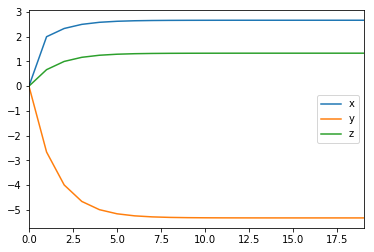

In [3]:
## Centralized Form

iterations = 20
x,y,z = [[float('NaN')]*iterations for i in range(3)]
x[0],y[0],z[0] = [0,0,0]

rho = 2
c = 4

for i in xrange(1,iterations):
    x[i] = 1/(2.+rho) * (c*rho - y[i-1] - rho*z[i-1])
    z[i] = 1/(4.+rho) * (c*rho - y[i-1] - rho*x[i])
    y[i] = y[i-1] + rho * (x[i] + z[i] - c)
    
print("Solution at x=%.3f, z=%.3f"%(x[-1],z[-1]))
df = pd.DataFrame([x,y,z],index=['x','y','z']).T
df.plot()

# Super-Simple Aggregator:
This is based on AggSimple.sol

Aggregator runs the simple conventional ADMM update step: $y^+ = y + \rho(Ax+Bz-c)$

No checks on the iteration number submitted from each of the participants, or the stopping number- this could keep getting called forever!

### Infrastructure setup:
This requires the following:
- **PATCHED** Ethjsonrpc: download from https://github.com/emunsing/ethjsonrpc and run setup.py
- Truffle: Used for deploying the contracts
- Testrpc: Useful for running a local test node
 
My process for deploying:
- Install Python packages including *the patched version from github of* `ethjsonrpc`
- Run `$ jupyter notebook` and run this iPython notebook
- In a separate terminal window, run `$ testrpc` to get a testrpc network going
- In a separate terminal window, run `$ truffle migrate --reset` to compile the contracts and deploy them to the test network

Caveats: This has not been deployed on the main Ethereum network (or even the testnet); it also has not been run through any security checks. The goal is for transparency and ease of teaching/exposition, not robustness or security!

In [4]:
from ethjsonrpc import EthJsonRpc, BadResponseError
conn = EthJsonRpc('127.0.0.1', 8545)

In [5]:
x_addr = conn.eth_accounts()[0]
z_addr = conn.eth_accounts()[1]

contractAddr = open('AggSimpleAddress.txt','rb').read()
contractAddr

'0xa5ab9b0b411ee608d4aecffaeea8d653aa6f61ad'

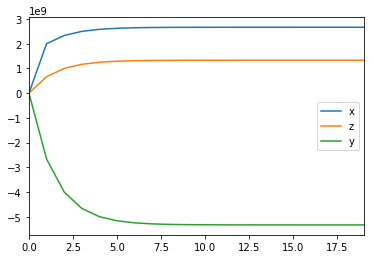

In [6]:
iterations = 20;
resultDf = pd.DataFrame(index = range(iterations),columns=['x','z','y'])

x_addr = conn.eth_accounts()[0]
z_addr = conn.eth_accounts()[1]

#### ADMM loop: Update x, update z, update y
# General information: this can be called separately by each participant
rho = conn.call(contractAddr,'rho()',[],['int256'])[0]
c   = conn.call(contractAddr,'c()',[],['int256'])[0]

i = 0
resultDf.loc[0,:] = [0,0,0]

for i in range(1, iterations):
    ### X LOCAL CALCULATION: need to retrieve z and y
    z = conn.call(contractAddr,'z()',[],['int256'])[0]
    y = conn.call(contractAddr,'y()',[],['int256'])[0]
    x = int( 1/(2.+rho) * (c*rho - y - rho*z) )
    # Submit the x-update
    tx = conn.call_with_transaction(x_addr, contractAddr, 'setX(int256)',[x])
    while conn.eth_getTransactionReceipt(tx) is None:
        time.sleep(0.1) # Wait for the transaction to be mined and state changes to take effect

    # Z LOCAL CALCULATION: This needs to processed after the x-update
    x = conn.call(contractAddr,'x()',[],['int256'])[0]
    y = conn.call(contractAddr,'y()',[],['int256'])[0]
    z = int( 1/(4.+rho) * (c*rho - y - rho*x) )
    tx = conn.call_with_transaction(z_addr, contractAddr, 'setZ(int256)',[z])
    while conn.eth_getTransactionReceipt(tx) is None:
        time.sleep(0.2) # Wait for the transaction to be mined and state changes to take effect

    # Update y: this happens on the blockchain
    tx = conn.call_with_transaction(x_addr, contractAddr, 'updateY()',[])
    while conn.eth_getTransactionReceipt(tx) is None:
        time.sleep(0.1) # Wait for the transaction to be mined and state changes to take effect
        
    # Save the values of the state for this iteration:
    y = conn.call(contractAddr,'y()',[],['int256'])[0]
    resultDf.loc[i,:] = [x,z,y]

resultDf.plot()

In [ ]:
# Use this if you want to reset the variable values to run it again
tx = conn.call_with_transaction(z_addr, contractAddr, 'setX(int256)',[0])
tx = conn.call_with_transaction(z_addr, contractAddr, 'setZ(int256)',[0])
tx = conn.call_with_transaction(z_addr, contractAddr, 'setY(int256)',[0])

# Manage access and make variable updates automatic

The contract `Aggregator.sol` extends the above approach in two important ways:
- Making sure that each participant can only update the variables which they are responsible for
- Checks whether the solution has converged to within acceptable bounds and we can consider the problem 'solved'

There are two stopping criteria which we want to satisfy: $||r^k||_2 \leq \epsilon^{\text{pri}},\; ||s^k||_2 \leq \epsilon^{\text{dual}}$ 
- **Primal Residual:**    $\quad r^{k+1} = Ax^{k+1} + Bz^{k+1} - c$
- **Dual Residual:**     $\quad s^{k+1} = \rho A^T B(z^{k+1} - z^k$)

These tolerances can be set in the smart contract by adjusting the variables `eps_pri` and `eps_dual`

In [7]:
x_addr = conn.eth_accounts()[0]
z_addr = conn.eth_accounts()[1]

contractAddr = open('AggregatorAddress.txt','rb').read()
contractAddr

'0xe192a96f1ebb53aa25fdd4f7879bf78b6649e48f'

Primal residual r=1333333334,	 Dual residual s=1333333332, 	 problemSolved is False
Primal residual r=666666666,	 Dual residual s=666666668, 	 problemSolved is False
Primal residual r=333333334,	 Dual residual s=333333332, 	 problemSolved is False
Primal residual r=166666666,	 Dual residual s=166666668, 	 problemSolved is False
Primal residual r=83333334,	 Dual residual s=83333332, 	 problemSolved is False
Primal residual r=41666666,	 Dual residual s=41666668, 	 problemSolved is False
Primal residual r=20833334,	 Dual residual s=20833332, 	 problemSolved is False
Primal residual r=10416666,	 Dual residual s=10416668, 	 problemSolved is False
Primal residual r=5208334,	 Dual residual s=5208332, 	 problemSolved is False
Primal residual r=2604166,	 Dual residual s=2604168, 	 problemSolved is False
Primal residual r=1302084,	 Dual residual s=1302082, 	 problemSolved is False
Primal residual r=651042,	 Dual residual s=651042, 	 problemSolved is False
Primal residual r=325520,	 Dual residual

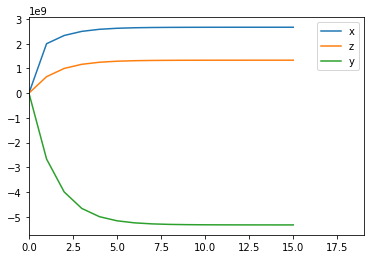

In [8]:
iterations = 20;
resultDf = pd.DataFrame(index = range(iterations),columns=['x','z','y'])

x_addr = conn.eth_accounts()[0]
z_addr = conn.eth_accounts()[1]

updateXfcn = 'submitValue(int256,uint16)'
updateZfcn = 'submitValue(int256,uint16)'
updateYfcn = None

#### ADMM loop: Update x, update z, update y
# General information: this can be called separately by each participant
rho = conn.call(contractAddr,'rho()',[],['int256'])[0]
c   = conn.call(contractAddr,'c()',[],['int256'])[0]

i = 0
resultDf.loc[0,:] = [0,0,0]

for i in range(1, 20):
    ### X LOCAL CALCULATION: need to retrieve z and y
    z = conn.call(contractAddr,'z()',[],['int256'])[0]
    y = conn.call(contractAddr,'y()',[],['int256'])[0]
    x = int( 1/(2.+rho) * (c*rho - y - rho*z) )
    # Submit the x-update
    tx = conn.call_with_transaction(x_addr, contractAddr, updateXfcn,[x,i], gas=int(300e3))
    while conn.eth_getTransactionReceipt(tx) is None:
        time.sleep(0.1) # Wait for the transaction to be mined and state changes to take effect

    # Z LOCAL CALCULATION: This needs to processed after the x-update
    x = conn.call(contractAddr,'x()',[],['int256'])[0]
    y = conn.call(contractAddr,'y()',[],['int256'])[0]
    z = int( 1/(4.+rho) * (c*rho - y - rho*x) )
    tx = conn.call_with_transaction(z_addr, contractAddr, updateZfcn,[z,i], gas=int(300e3))
    while conn.eth_getTransactionReceipt(tx) is None:
        time.sleep(0.2) # Wait for the transaction to be mined and state changes to take effect

    # Update y: this happens on the blockchain
    if updateYfcn is not None:
        tx = conn.call_with_transaction(x_addr, contractAddr, 'updateY()',[])
        while conn.eth_getTransactionReceipt(tx) is None:
            time.sleep(0.1) # Wait for the transaction to be mined and state changes to take effect
        
    # Save the values of the state for this iteration:
    y = conn.call(contractAddr,'y()',[],['int256'])[0]
    resultDf.loc[i,:] = [x,z,y]
    r = conn.call(contractAddr,'r()',[],['int256'])[0]
    s = conn.call(contractAddr,'s()',[],['int256'])[0]
    solved =  conn.call(contractAddr,'problemSolved()',[],['bool'])[0]
    print("Primal residual r=%s,\t Dual residual s=%s, \t problemSolved is %s"%(r,s,solved))
    if solved: break
    

resultDf.plot()